In [330]:
import os
import librosa
import sklearn
import scipy
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import noisereduce as nr
from tqdm import tqdm
from scipy.io import wavfile

In [331]:
# Define paths
csv_file = 'common-voice/versions/2/cv-valid-train.csv'
mp3_folder = 'common-voice/versions/2/cv-valid-train'
output_csv = "common-voice/versions/2/train_features.csv"

sr = 16000          # sample_rate
length_of_audio = 5 # seconds

In [332]:
df = pd.read_csv(csv_file)
df.drop(['text', 'up_votes', 'down_votes', 'duration'], axis=1, inplace=True)
df.dropna(inplace=True)
print(df.shape)
print(df.head(1))

(63163, 4)
                           filename       age  gender accent
5  cv-valid-train/sample-000005.mp3  twenties  female     us


In [333]:
tags = {
    'age': df['age'].unique(),
    'gender': df['gender'].unique(),
    'accent': df['accent'].unique()
}
mapping = {}
for key in tags:
    for id, option in enumerate(tags[key]):
        mapping[option] = id
# print(mapping)

In [334]:
df['age'] = df['age'].map(mapping)
df['gender'] = df['gender'].map(mapping)
df['accent'] = df['accent'].map(mapping)

In [335]:
print(df.head(5))
print(df.shape)

                            filename  age  gender  accent
5   cv-valid-train/sample-000005.mp3    0       0       0
8   cv-valid-train/sample-000008.mp3    1       1       0
13  cv-valid-train/sample-000013.mp3    2       0       0
14  cv-valid-train/sample-000014.mp3    3       1       1
19  cv-valid-train/sample-000019.mp3    4       1       2
(63163, 4)


In [336]:
def preprocessing(file, sample_rate, fixed_length = sr * length_of_audio):
    y, sr = librosa.load(file)
    reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)
    y_trim, _ = librosa.effects.trim(reduced_noise, top_db=20)
    # Standardize length so fft produce same frequency
    if len(y_trim) < fixed_length:
        y_trim = np.pad(y_trim, (0, fixed_length - len(y_trim)), mode='constant')
    else:
        y_trim = y_trim[:fixed_length]
    return y_trim, sr

In [337]:
def onset(y, sr):
    onsets = librosa.onset.onset_detect(y=y, sr=sr, units="time", hop_length=128, backtrack=True)
    number_of_words = len(onsets)
    duration = librosa.get_duration(y=y,sr=sr)
    word_per_sec = number_of_words/duration
    return  number_of_words, duration, word_per_sec

In [338]:
def pitch(y, sr):
    f0, _, _ = librosa.pyin(y, sr=sr, fmin=10, fmax=8000, frame_length=1024)
    f0_values = {
    'f0_mean' : np.nanmean(f0),
    'f0_median' : np.nanmedian(f0),    
    'f0_std' : np.nanstd(f0),
    'f0_5-percentile' : np.nanpercentile(f0, 5),
    'f0_95-percentile' : np.nanpercentile(f0, 95),
    }
    return f0_values

In [339]:
def fft(y,sr):
    # Compute FFT
    y_freq = np.abs(scipy.fftpack.fft(y))
    f = np.linspace(0, sr, len(y_freq))  # Frequency axis
    
    # Filter frequencies in the range [100, 1000] Hz
    freq_range = (f >= 100) & (f <= 1000)
    filtered_frequencies = f[freq_range]
    filtered_magnitudes = y_freq[freq_range]
    
    # Restrict data points to 500 by uniform sampling
    indices = np.linspace(0, len(filtered_frequencies) - 1, 500, dtype=int)
    sampled_frequencies = filtered_frequencies[indices]
    sampled_magnitudes = filtered_magnitudes[indices]
    result = {sampled_frequencies[i]: sampled_magnitudes[i] for i in range(len(indices))}
    return result

In [326]:
new_features = {
    'number_of_words': [],
    'duration': [],
    'word_per_sec': [],
    'tempo': []
}

mp3_filename = "cv-valid-train/sample-000005.mp3" 
mp3_file_path = os.path.join(mp3_folder, mp3_filename)
y, sr = librosa.load(mp3_file_path)
y_trim,sr = preprocessing(mp3_file_path,sr)

f0_values = pitch(y=y_trim, sr=sr)
for key in f0_values.keys():
    new_features[key] = []
        # FFT
magnitudes = fft(y=y_trim, sr=sr)
for key in magnitudes.keys():
    new_features[key] = []


In [ ]:
# df_sampled = df[:len(df) // 10] 

In [341]:
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing MP3 files", unit="file"):
    mp3_filename = row['filename']  # Adjust if column name differs
    mp3_file_path = os.path.join(mp3_folder, mp3_filename)
    
    # Check if the MP3 file exists
    if os.path.exists(mp3_file_path):
        # preprocessing
        y, sample_rate = preprocessing(mp3_file_path,sr)
        
        # Onset
        number_of_words, duration, word_per_sec = onset(y=y, sr=sample_rate)
        new_features['number_of_words'].append(number_of_words)
        new_features['duration'].append(duration)
        new_features['word_per_sec'].append(word_per_sec)
        
        # Tempo
        tempo = librosa.feature.rhythm.tempo(y=y, sr=sr, start_bpm=10)[0]
        new_features['tempo'].append(tempo)
        
        # Pitch
        f0_values = pitch(y=y, sr=sample_rate)
        for i, v in f0_values.items():
            new_features.setdefault(i, []).append(v)
        
        # FFT
        magnitudes = fft(y=y, sr=sample_rate)
        for i, v in magnitudes.items():
            new_features.setdefault(i, []).append(v)

# Convert the new features dictionary into a DataFrame
new_features_df = pd.DataFrame(new_features)

# Concatenate the new features with the original DataFrame
df = pd.concat([df, new_features_df], axis=1)

print("Finished extracting MP3 files.")

Processing MP3 files:   0%|          | 89/63163 [08:13<97:05:46,  5.54s/file] 


SystemError: CPUDispatcher(<function _viterbi at 0x00000179E5C1A3E0>) returned a result with an exception set

In [329]:
df

,filename,age,gender,accent,number_of_words,duration,word_per_sec,tempo,f0_mean,f0_median,...,983.717921,985.371692,987.301091,988.954862,990.884261,992.538032,994.467431,996.121202,998.050601,999.98
5,cv-valid-train/sample-000005.mp3,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,21.0,3.628118,5.788125,26.639014,200.079001,195.848567,...,3.085726,2.231493,2.676073,1.962836,1.813702,2.208221,1.677236,2.026507,1.45727,0.735246


In [79]:
df.to_csv(output_csv, index=False)

# Single Test: preprocessing

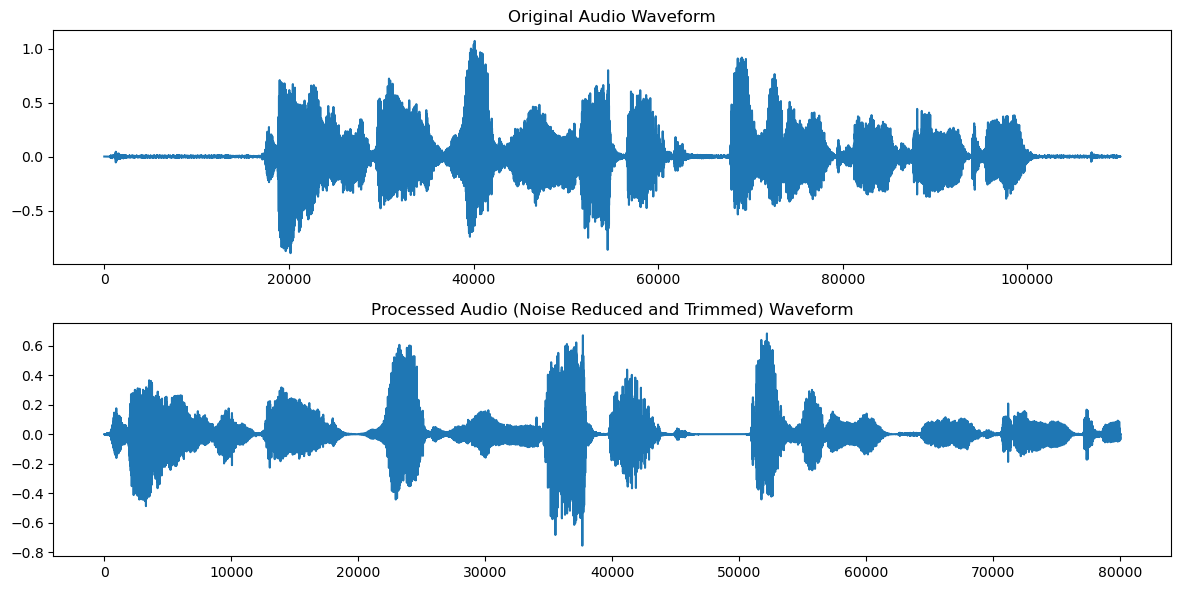

In [307]:
mp3_filename = "cv-valid-train/sample-000026.mp3" 
mp3_file_path = os.path.join(mp3_folder, mp3_filename)
y, sr = librosa.load(mp3_file_path)
y_trim,sr = preprocessing(mp3_file_path,sr)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y)
plt.title('Original Audio Waveform')

plt.subplot(2, 1, 2)
plt.plot(y_trim)
plt.title('Processed Audio (Noise Reduced and Trimmed) Waveform')

plt.tight_layout()
plt.show()

# Single Test: Onset

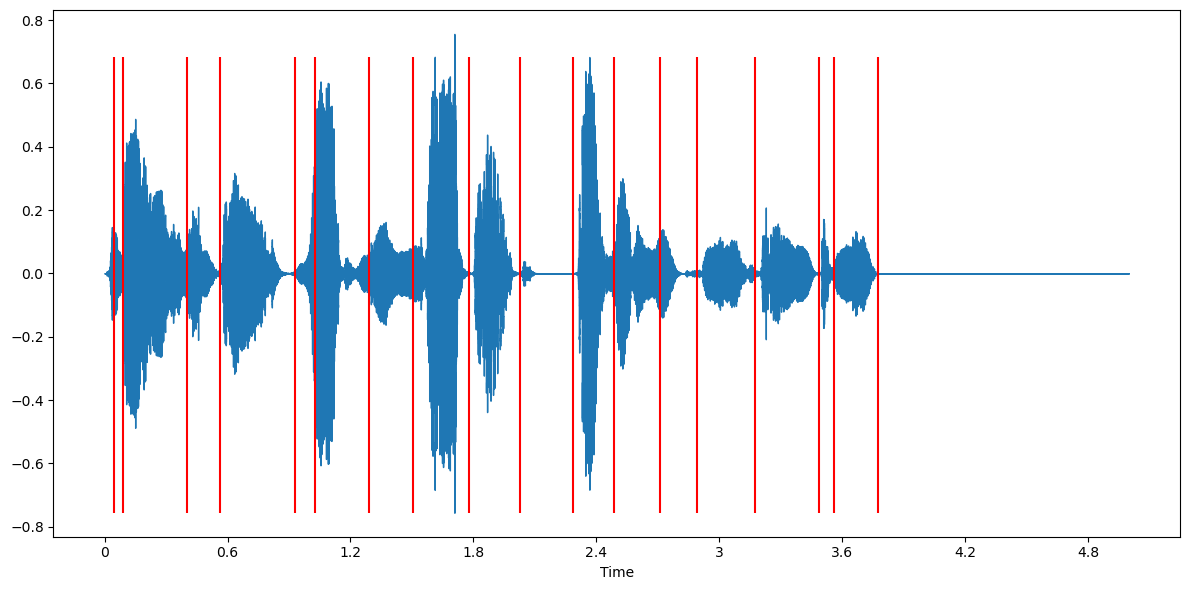

18 onsets were detected in this audio signal.
5.0


In [236]:
onsets = librosa.onset.onset_detect(y=y_trim, sr=sr, units="time", hop_length=128, backtrack=True)
plt.figure(figsize=(12, 6))
for o in onsets:
    plt.vlines(o, min(y_trim), max(y_trim), colors="r")
librosa.display.waveshow(y_trim,sr=sr)
plt.tight_layout()
plt.show()
# Return number of onsets
number_of_words = len(onsets)
print(f"{number_of_words} onsets were detected in this audio signal.")

duration = librosa.get_duration(y=y_trim,sr=sr)
print(duration)

# Single Test: Fundamental frequency

# Single Test: FFT

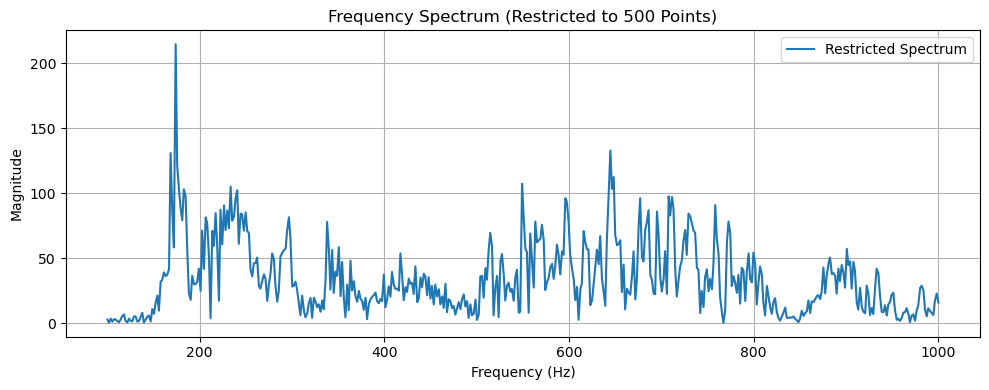

In [308]:
r = fft(y_trim,sr)
sampled_frequencies = r.keys()
sampled_magnitudes = r.values()
# Plot the restricted spectrum
plt.figure(figsize=(10, 4))
plt.plot(sampled_frequencies, sampled_magnitudes, label="Restricted Spectrum")
plt.title("Frequency Spectrum (Restricted to 500 Points)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [309]:
r

{np.float64(100.0531256640708): np.float32(2.915732),
 np.float64(101.70689633620421): np.float32(0.5273013),
 np.float64(103.63629545369318): np.float32(3.588538),
 np.float64(105.29006612582658): np.float32(1.3194726),
 np.float64(107.21946524331555): np.float32(3.1835983),
 np.float64(108.87323591544894): np.float32(2.9999745),
 np.float64(110.80263503293791): np.float32(1.6629537),
 np.float64(112.45640570507132): np.float32(0.9028995),
 np.float64(114.38580482256029): np.float32(2.9714828),
 np.float64(116.0395754946937): np.float32(5.5136213),
 np.float64(117.96897461218266): np.float32(6.844934),
 np.float64(119.62274528431607): np.float32(1.9418025),
 np.float64(121.55214440180504): np.float32(0.7401457),
 np.float64(123.48154351929401): np.float32(3.6166859),
 np.float64(125.1353141914274): np.float32(1.9179573),
 np.float64(127.06471330891637): np.float32(1.6259979),
 np.float64(128.7184839810498): np.float32(5.2786903),
 np.float64(130.64788309853873): np.float32(5.245609),


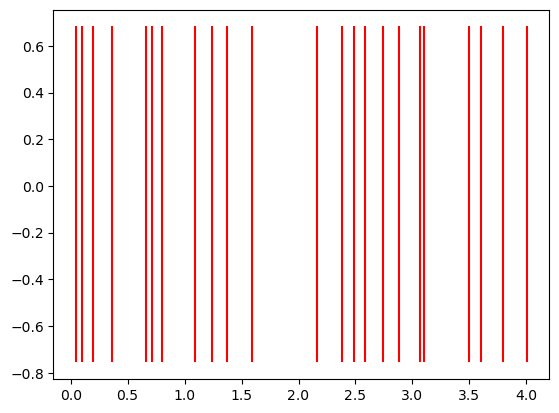

In [246]:
y, sample_rate = preprocessing(mp3_file_path,sr)
        
# Onset
number_of_words, duration, word_per_sec  = onset(y=y, sr=sample_rate)



In [ ]:
# # Iterate over each row in the DataFrame
# for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing MP3 files", unit="file"):
#     mp3_filename = row['filename']  # Adjust if column name differs
#     mp3_file_path = os.path.join(mp3_folder, mp3_filename)
#     
#     # Check if the MP3 file exists
#     if os.path.exists(mp3_file_path):
#         # preprocessing
#         y, sample_rate = preprocessing(mp3_file_path,sr)
#         
#         # Onset
#         number_of_words, duration, word_per_sec  = onset(y=y, sr=sample_rate)
#         df.at[index, 'number_of_words'] = number_of_words
#         df.at[index, 'duration'] = duration
#         df.at[index, 'word_per_sec'] = word_per_sec
#         # Tempo
#         tempo = librosa.feature.rhythm.tempo(y=y, sr=sample_rate, start_bpm=10)[0]
#         df.at[index, 'tempo'] = tempo
#         # Pitch
#         f0_values = pitch(y=y, sr=sample_rate)
#         for i, v in f0_values.items():
#             df.at[index, i] = v
#         # FFT
#         magnitudes = fft(y=y, sr=sample_rate)
#         for i, v in magnitudes.items():
#             df.at[index, i] = v
#         
# 
# print("Finished extracting MP3 files.")